<a href="https://colab.research.google.com/github/Many98/GLM_R2Py/blob/main/Python/01ZLMA_ex03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 03
Exercise 03 of the course 01ZLMA. 

## Contents

* Statistical Inference
 ---
* Testing
 ---




#  Necessary theory recap from Lecture 04

Under the conditions of regularity holds

1.  $ \ U(\beta) \sim N_{p}(0,I(\beta)) \Rightarrow  I^{-\frac{1}{2}}(\beta)\, U(\beta) {\stackrel{D}{\longrightarrow}} N_{p}(0, 1)$
2. $ U(\beta)I^{-1}(\beta)U(\beta)\sim \chi^{2}(p) \Rightarrow U(\beta)^T I^{-1}(\beta)U(\beta)  {\stackrel{D}{\longrightarrow}} \chi^{2}(p)$
3. Consistency of $\hat{\beta}$ and Wald statistics: \\
 $\hat{\beta}\sim N_{p}(\beta,I^{-1}(\beta)) \Rightarrow
(\hat{\beta}-\beta)^T I(\beta)(\hat{\beta}-\beta) {\stackrel{D}{\longrightarrow}} \chi^{2}(p)$



Saturated and null model

* Null model: $\mu_i = \mu, \forall i \in \{1, \ldots , n\}$ \\
The Null Model assumes one parameter for all of the data points, which means you only estimate 1 parameter. 
* Saturated model: $Y_i = \hat{\mu_i}, \forall i \in \{1, \ldots , n\}$ \\
The Saturated Model is a model that assumes each data point has its own parameters, which means you have n parameters to estimate.
* Proposed Model:  model, where you try to explain your data points with $p$ parameters + an intercept term, so you have p+1 parameters, where $1 \leq p \leq n$.

Questions:
* What is the difference between null and saturated model?
* Which model has greater log-likelihoood value?
* Which model has the highest log-likelihood value?
* What can you say about asymptotic distributions of $\hat{\beta}$ and $U(\hat{\beta})$ for saturated model?

## Let's code 

In [1]:
import numpy as np
import scipy
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.api import abline_plot

import pandas as pd

from helpers import _F_, _chisq_, _rao_, DiagnosticPlots

Use Example 2 from the last Exercise 02

In [2]:
n  = 20 # n observations
m  = 2 # m parameters to estimate
X1 = np.ones((n*m,))  # Intercept
X2 = np.array([i for i in range(1, n+1)] * m) # Regressors
X = np.vstack([X1, np.log(X2)]).T # design matrix
beta = np.array([0.9, 1.3]) # Regression coefficients
lamdas = np.exp(X @ beta) # Means
Y = np.random.poisson(lamdas, n*m) # Response variable with Poisson distribution

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -126.04
Date:                Sun, 04 Sep 2022   Deviance:                       35.958
Time:                        13:46:20   Pearson chi2:                     32.8
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9849      0.128      7.673      0.0

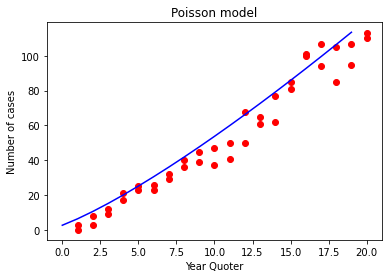

In [3]:
# to create models we can use standard api or formula (r-like) api in statsmodels
# formula api requires dataset (pandas) and formula
d = pd.DataFrame(data={'Y': Y, 'X1': X1, 'X2':X2})
#model = smf.glm(formula='Y~np.log(X2)', data=d, family=sm.families.Poisson()).fit()

# standard api requires specifying endog (response) and exog (explanatory) design matrices
model = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit()
print(model.summary())

beta_e = model.params; print(f'estimated params are:{beta_e}')
y_hat = model.predict(); print(f'fitted values are:{y_hat}')

fig, ax = plt.subplots()
ax.scatter(X2, Y, color='red', marker='o')
ax.plot(np.unique(y_hat), color='blue')
ax.set_title('Poisson model')
ax.set_xlabel('Year Quoter')
ax.set_ylabel('Number of cases')
plt.show()

Repetition using custom function:

In [4]:
# function to calcualate weights W
def calc_W_inv(X, beta):
    return np.diag(np.exp(X @ beta))

In [5]:
# function to calcualate weights Z
def calc_Z(X,Y,beta):
    return X@beta + (Y - np.exp(X@beta)) / np.exp(X@beta)

In [6]:
# IWLS for example 2

def IWLS(X,Y,beta_init,maxiter,epsilon):
    res = {'FM': None, 'SV': None, 'betas': None}
    # Fisher-scoring algorithm
    i = 1     # first iteration

    beta_i = beta_init
    
    while i <= maxiter:
        W = calc_W_inv(X,beta_i)
        Z = calc_Z(X,Y,beta_i)
        beta_pred = beta_i
        beta_i = np.linalg.solve(X.T@W@X, X.T@W@Z)
        diff = np.max(np.abs(beta_i - beta_pred))
        if diff < epsilon:
            break
        W = calc_W_inv(X, beta_i)
        Z = calc_Z(X, Y, beta_i)

        res['SV'] = X.T@W@Z
        res['FM'] = X.T@W@X
        res['betas'] = np.linalg.solve(X.T@W@X, X.T@W@Z)
        i += 1
    return res

In [7]:
# Estimation of betas
result1 = IWLS(X,Y,np.ones(2),100,10^(-6))
print(f'Estimation of parameters: {result1["betas"]}')      # Estimation of parameters
print(f'Estimated Fisher information matrix: {result1["FM"]}')        # Estimated Fisher information matrix
print(f'Estimated covariance matrix: {np.linalg.inv(result1["FM"])}')  # Estimated covariance matrix  = Inverse of estimated Fisher information matrix


Estimation of parameters: [0.98486653 1.25084551]
Estimated Fisher information matrix: [[ 2132.          5492.88418099]
 [ 5492.88418099 14566.53119863]]
Estimated covariance matrix: [[ 0.01647671 -0.00621319]
 [-0.00621319  0.00241158]]


Comparison of our custom solution with the built in glm function:

In [8]:
print(model.summary())

# the unscaled (dispersion = 1) estimated covariance matrix of the estimated coefficients.
FIM1 = model.cov_params()
print(f'estimated covariance matrix {FIM1}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -126.04
Date:                Sun, 04 Sep 2022   Deviance:                       35.958
Time:                        13:46:20   Pearson chi2:                     32.8
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9849      0.128      7.673      0.0

In [9]:
# to find out what params has `model` object
for attr in dir(model):
    if not attr.startswith('_'):
        print(attr)

aic
bic
bic_deviance
bic_llf
bse
conf_int
converged
cov_kwds
cov_params
cov_type
deviance
df_model
df_resid
f_test
family
fit_history
fittedvalues
get_hat_matrix_diag
get_influence
get_prediction
info_criteria
initialize
k_constant
llf
llf_scaled
llnull
load
method
mle_settings
model
mu
nobs
normalized_cov_params
null
null_deviance
params
pearson_chi2
plot_added_variable
plot_ceres_residuals
plot_partial_residuals
predict
pseudo_rsquared
pvalues
remove_data
resid_anscombe
resid_anscombe_scaled
resid_anscombe_unscaled
resid_deviance
resid_pearson
resid_response
resid_working
save
scale
summary
summary2
t_test
t_test_pairwise
tvalues
use_t
wald_test
wald_test_terms


Asymptotics:

* $ (\hat{\beta} - \beta) \sim N_{p}(0, I^{-1}(\beta))$ 
* Estimated Fisher information matrix  $\hat{I}(\hat{\beta}) = (X^T \hat{W} X)$  matrix.
*  Estimated covariance matrix $\hat{V} (\hat{\beta}) = (X^T \hat{W} X)^{-1}$ 

In [10]:
n = 10
repet = 50
n_observ = np.array([1,2,5,10,100, 500])
betas_hat = np.zeros((6, repet, 2))

for _, i in enumerate(n_observ):
    for j in range(repet):
        X1 = np.ones((n*i,))
        X2 = np.array([i for i in range(1, n+1)]*i)
        X  = np.vstack([X1, np.log(X2)]).T
        beta = np.array([0.9, 1.3]) # Regression coefficients
        lamdas = np.exp(X @ beta) # Means
        Y = np.random.poisson(lamdas, n*i)
        betas_hat[_, j] = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit().params


In [11]:

for i in range(len(n_observ)):
    print(f"Number of observations: {n_observ[i]*n}")
    print(np.cov((betas_hat[i] - beta).T))
    print(np.mean(betas_hat[i] - beta))

Number of observations: 10
[[ 0.09708017 -0.04851289]
 [-0.04851289  0.02529382]]
-0.01170606534877119
Number of observations: 20
[[ 0.04006742 -0.01973858]
 [-0.01973858  0.01019843]]
0.002502889456821864
Number of observations: 50
[[ 0.01911297 -0.00957033]
 [-0.00957033  0.00501067]]
-0.010083101814278517
Number of observations: 100
[[ 0.01072908 -0.00524226]
 [-0.00524226  0.0026544 ]]
-0.006353013646148668
Number of observations: 1000
[[ 0.00089333 -0.00045069]
 [-0.00045069  0.00023628]]
-0.002151301270871927
Number of observations: 5000
[[ 1.78188374e-04 -8.96905079e-05]
 [-8.96905079e-05  4.70834417e-05]]
-0.0007808509091474103


## Hypothesis testing

Use the model from the beginning again.

In [12]:
n  = 20
m  = 2

X1 = np.ones((n*m,))
X2 = np.array([i for i in range(1, n+1)]*m)
X  = np.vstack([X1, np.log(X2)]).T
beta = np.array([0.9, 1.3]) # Regression coefficients
lamdas = np.exp(X @ beta) # Means
Y = np.random.poisson(lamdas, n*m)



In [13]:
model = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson()).fit()
print(model.summary())

# the unscaled (dispersion = 1) estimated covariance matrix of the estimated coefficients.
FIM1 = model.cov_params()
print(f'estimated covariance matrix {FIM1}')


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.39
Date:                Sun, 04 Sep 2022   Deviance:                       55.648
Time:                        13:46:21   Pearson chi2:                     56.1
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9889      0.125      7.911      0.0

Calculation of Z value
 $$Z_i = \frac{\hat{\beta_i}}{(I^{-1}(\hat{\beta_i}))_{ii}}$$

In [14]:
# Testing statistics from summary table
model.summary()

 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.39
Date:                Sun, 04 Sep 2022   Deviance:                       55.648
Time:                        13:46:21   Pearson chi2:                     56.1
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9889      0.125      7.911      0.000       0.744       1.234
x1             1.2812      0.048     26.842      0.000       1.188       1.375
==============================================================================
"""

In [15]:
# By definition

z_stat = model.params / np.sqrt(np.diag(model.cov_params()))
print(z_stat)
z_stat == model.tvalues

[ 7.91115213 26.84227053]


array([ True,  True])

In [16]:
# p-values of the test
p_val = 2*scipy.stats.norm.sf(z_stat, loc=0, scale=1)
print(f'pval: {p_val}')
p_val == model.pvalues

pval: [2.55017660e-015 1.03826267e-158]


array([ True,  True])

In [17]:
### 100(1-alpha) confidence interval
alpha = 0.05
u = scipy.stats.norm.ppf(1-alpha/2,0,1)
CI_LB = model.params[1] - u * np.sqrt(np.diag(model.cov_params())[1])
CI_UB = model.params[1] + u * np.sqrt(np.diag(model.cov_params())[1])

print(f"2.5% CI = {CI_LB},ESTIM = {model.params[1]}, 97.5% CI = {CI_UB}")


# built in function
print(model.conf_int())

2.5% CI = 1.187675117929638,ESTIM = 1.2812275565905769, 97.5% CI = 1.3747799952515156
[[0.74386571 1.23383509]
 [1.18767512 1.37478   ]]


Question:

* Compare hypothesis testing in LM vs. GLM

# Deviance

Deviance is a measure of goodness of fit of a GLM. 


Log-likelihood of the saturated model is the highest possible one with given data, $\tilde{\mu}_i = y_i$ and $\tilde{\theta_i} = \theta(y) = (b')^{-1}(y_i)$.
$$l(\tilde{\mu},\phi;y)=\sum_{i=1}^{n}\frac{y_{i}\tilde{\theta}_{i}-b(\tilde{\theta}_{i})}{a_{i}(\phi)}+\sum_{i=1}^{n}c(y_i,\phi)$$

Scale deviance statistics:
$${S(y,\hat{\mu},\phi)}=2\left[l(\tilde{\mu},\phi;y)-l(\hat{\mu},\phi;y)\right]
=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}(\phi)}.
$$

Deviance:
Let $a_{i}(\phi)=a_{i}\phi$, then
$$S(y,\hat{\mu},\phi)=\frac{D(y,\hat{\mu})}{\phi},
$$
and
$$
D(y,\hat{\mu})=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}}
$$

### Comparison of two models

Assume model $D_0$ with $p_0$ paramters and its sub-model $D_1$ with $p_1$ parameters, then
$$ \frac{1}{\phi} (D_0 - D_1) \sim \chi(p_0 - p_1) $$

Question:
* Can we take deviance as a measure of the model quality?
* Can we use deviance as a measure of the saturated model quality?
* Complete the sentence: Compare two GLMs with deviance is like compare two LMs with ...

In [18]:
# Add random variable to the previous model 
Z = scipy.stats.uniform.rvs(loc=0, scale=1, size=n*m)
model_0 = sm.GLM(endog=Y, exog=np.hstack([X, Z[:, None]]), family=sm.families.Poisson()).fit()
model_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       37
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.39
Date:                Sun, 04 Sep 2022   Deviance:                       55.646
Time:                        13:46:21   Pearson chi2:                     56.1
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9906      0.133      7.469      0.000       0.731       1.251
x1             1.2811      0.048     26.750      0.000       1.187       1.375
x2            -0.0026      0.065     -0.040      0.968      -0.130       0.125
==============================================================================
"""

In [19]:
# Proposed model
m1 = sm.GLM(endog=Y, exog=X, family=sm.families.Poisson())
model_1 = m1.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.39
Date:                Sun, 04 Sep 2022   Deviance:                       55.648
Time:                        13:46:21   Pearson chi2:                     56.1
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9889      0.125      7.911      0.000       0.744       1.234
x1             1.2812      0.048     26.842      0.000       1.188       1.375
==============================================================================
"""

In [20]:
# Null model

model_n = sm.GLM(endog=Y, exog=X[:, 0], family=sm.families.Poisson()).fit()
model_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -690.66
Date:                Sun, 04 Sep 2022   Deviance:                       1162.2
Time:                        13:46:21   Pearson chi2:                 1.01e+03
No. Iterations:                     4   Pseudo R-squ. (CS):          1.710e-14
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0583      0.021    195.262      0.000       4.018       4.099
==============================================================================
"""

In [23]:
# Saturated model CANNOT BY OBTAINED BY STATSMODELS BY DEFAULT 'CAUSE THEY PREVENT ZERO DIVISION

# BUT MY WORKAROUND WHICH PROBABLY WILL NOT WORK IN COLAB AS WE DO NOT HAVE ACCESS TO MODULES IS
# TO COMMENT OUT ROWS 1227-1229 IN MOST RECENT VERSION 
# (SEE https://github.com/statsmodels/statsmodels/blob/main/statsmodels/genmod/generalized_linear_model.py)

I = np.diag(np.ones((m*n,)))


model_s = sm.GLM(endog=Y, exog=I, family=sm.families.Poisson()).fit()
print(model_s.summary())
print(f'Residual deviance is: {model_s.deviance}')



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   40
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -109.57
Date:                Sun, 04 Sep 2022   Deviance:                   4.8850e-14
Time:                        13:46:22   Pearson chi2:                 3.70e-28
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.538e-16      1.000   1.54e-16      1.0

/media/emanuel/data/miniconda3/lib/python3.9/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


For Poisson model:
$$D = 2 \sum_{i=1}^n y_i log( \frac{y_i}{\hat{\mu_i}})$$

In [24]:
mu_est_0 = model_0.predict()
mu_est_1 = model_1.predict()

Dev_0 = 2*np.sum(Y*np.log(Y/mu_est_0))
print(Dev_0)
Dev_1 = 2*np.sum(Y*np.log(Y/mu_est_1))
print(Dev_1)


55.646145324165424
55.64771839392723


## Anova testing 
from anova.glm?

The table will optionally contain test statistics (and P values) comparing the reduction in deviance for the row to the residuals. For models with known dispersion (e.g., binomial and Poisson fits) the chi-squared test is most appropriate, and for those with dispersion estimated by moments (e.g., gaussian, quasibinomial and quasipoisson fits) the F test is most appropriate. 

Mallows' Cp statistic is the residual deviance plus twice the estimate of $sigma^2$ times the residual degrees of freedom, which is closely related to AIC (and a multiple of it if the dispersion is known). You can also choose "LRT" and "Rao" for likelihood ratio tests and Rao's efficient score test. The former is synonymous with "Chisq" (although both have an asymptotic chi-square distribution). 

In [25]:
anova(model_1)
anova(model_1, test = "Cp")
anova(model_1, test = "Chisq")

anova(model_1, model_0, test = "Rao")
anova(model_1, model_0, test = "LRT")   
  

NameError: name 'anova' is not defined

In [ ]:
# p-value of deviance tst
# H0: model fit data
p_dev <- pchisq(model_1$deviance, model_1$df.residual, ncp=0, lower.tail = FALSE)
p_dev

# critical value
C_val <- qchisq(0.05, model_1$df.residual, ncp=0, lower.tail = FALSE)
C_val

#summary(model_1)
#pchisq(1168 - 44, df=(39-38))

anova(model_1,model_s, test = "LRT")   # saturated vs. final model



## Rao statistics

In [ ]:
######## Rao score statistics (for Poisson GLM)

score = model_1.resid_response / model_1.model.family.variance(model_1.predict())
rao = score.T @  np.diag(model_1.model.family.variance(model_1.predict())) @ score
print(f'rao score statistic: {rao}')

# p-hodnota testu adekvatnosti modelu (pomoci Raovy statistiky)
# H0: model dobre popisuje data

print(f'p-val of rao test: {scipy.stats.chi2.sf(rao, df=model_1.df_resid)}')

######  pomoci saturovaneho modelu
model_1.model.score_test()
#anova(model_1,model_s, test = "Rao")

In [ ]:
model_1.model.family.variance(model_1.predict())

In [ ]:
Y-mu_est_1

In [ ]:
model_1.resid_response

In [ ]:
model_1.resid_pearson @ model_1.resid_pearson.T 

In [ ]:
_rao_(model_1, model_0)

In [ ]:
R = np.array(([1,1]))
model_1.wald_test(R, scalar=True)
#model_0.deviance


In [ ]:
_F_(model_n, model_1)

# Your turn:
1. Generate data with followings parameters
 * $Y \sim Poi(\mu_i)$, where $E[Y_i] = \mu_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} = x_i^T \beta \  \Rightarrow \ q(\mu_i) = \mu_i =  x_i^T \beta  = \eta_i$
* $X_{i1} \sim N(50,10)$
* $X_{i2} \sim U(10,60)$
* $X_{i3} \sim Ber(0.45)$
* $n = 40$
2. Compute $\hat{\mu_i}$  for saturated, null,"full","best" models.
3. Compute Deviance, Rao, Wald statistics for your model and compare final model with the saturated and "full" ones.
4. Generate 100x data for  $n \in \{20,40,60,80,100 \}$ and plot $(\hat{\beta_i} -\beta_i)$ vs. $(n)$
